<a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Game of Thrones Book Data Analysis**
This notebook contains an exporatory data analysis of survival of characters in George RR Martin’s “A Song of Fire and Ice” book series. It uses character-predictions.csv. Sourced from Kaggle, this csv lists features of 1946 characters. It was created by the team at A Song of Ice and Data by scraping the Westeros wiki http://awoiaf.westeros.org.   

### **SETUP -- Import Libraries, Models & Metrics**
To run this notebook in your browser click the "Open in Colab" button. Below are the libraries, models and metrics we'll use.

In [1]:
import pandas as pd # data processing
import numpy as np # linear algebra
import seaborn as sns # for visuals
import matplotlib.pyplot as plt # for graphs
%matplotlib inline # how graphs are printed
plt.style.use('ggplot') 
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

UsageError: unrecognized arguments: # how graphs are printed


### **LOAD & CLEAN DATA**
Use pandas to import the CSV file from a Google Cloud bucket into a dataframe. 

In [2]:
# import csv
df_raw = pd.read_csv('https://storage.googleapis.com/storytelling-megano/raw-data/character-predictions.csv')
df_raw.head()

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
S.No                 1946 non-null int64
actual               1946 non-null int64
pred                 1946 non-null int64
alive                1946 non-null float64
plod                 1946 non-null float64
name                 1946 non-null object
title                938 non-null object
male                 1946 non-null int64
culture              677 non-null object
dateOfBirth          433 non-null float64
DateoFdeath          444 non-null float64
mother               21 non-null object
father               26 non-null object
heir                 23 non-null object
house                1519 non-null object
spouse               276 non-null object
book1                1946 non-null int64
book2                1946 non-null int64
book3                1946 non-null int64
book4                1946 non-null int64
book5                1946 non-null int64
isAliveMother        21 non

In [4]:
df_raw.describe()

,S.No,actual,pred,alive,plod,male,dateOfBirth,DateoFdeath,book1,book2,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,433.000000,444.000000,1946.000000,1946.000000,...,23.000000,276.000000,1946.000000,1946.000000,433.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,973.500000,0.745632,0.687050,0.634470,0.365530,0.619219,1577.364896,2950.193694,0.198356,0.374615,...,0.652174,0.778986,0.141829,0.460946,-1293.563510,0.305755,0.074512,0.059096,0.089584,0.745632
std,561.906131,0.435617,0.463813,0.312637,0.312637,0.485704,19565.414460,28192.245529,0.398864,0.484148,...,0.486985,0.415684,0.348965,0.498601,19564.340993,1.383910,0.262669,0.235864,0.160568,0.435617
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-28.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-298001.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,487.250000,0.000000,0.000000,0.391250,0.101000,0.000000,240.000000,282.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.013378,0.000000
50%,973.500000,1.000000,1.000000,0.735500,0.264500,1.000000,268.000000,299.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.033445,1.000000
75%,1459.750000,1.000000,1.000000,0.899000,0.608750,1.000000,285.000000,299.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,50.000000,0.000000,0.000000,0.000000,0.086957,1.000000
max,1946.000000,1.000000,1.000000,1.000000,1.000000,1.000000,298299.000000,298299.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,100.000000,15.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# check number of rows and columns
df_raw.shape

(1946, 33)

Let's work on a subset of the data with characters from the 9 major houses and the Night's Watch. The 9 major houses are: Stark, Arryn, Baratheon, Tully, Greyjoy, Lannister, Tyrell, Martell and Targaryen. 

In [6]:
# Create a list of the 9 major houses + Night's Watch
major_houses = ['House Stark', 'House Arryn', 'House Baratheon', 'House Tully',
       'House Greyjoy', 'House Lannister', 'House Tyrell', 'House Martell', 
       'House Targaryen', "Night's Watch"]

# Create a dataframe by selecting rows matching major houses
df = df_raw[df_raw['house'].isin (major_houses)]
df.house.unique()

array(['House Arryn', 'House Targaryen', "Night's Watch", 'House Greyjoy',
       'House Stark', 'House Tyrell', 'House Lannister', 'House Martell',
       'House Baratheon', 'House Tully'], dtype=object)

In [7]:
df.shape

(435, 33)

In [8]:
df.columns

Index([u'S.No', u'actual', u'pred', u'alive', u'plod', u'name', u'title',
       u'male', u'culture', u'dateOfBirth', u'DateoFdeath', u'mother',
       u'father', u'heir', u'house', u'spouse', u'book1', u'book2', u'book3',
       u'book4', u'book5', u'isAliveMother', u'isAliveFather', u'isAliveHeir',
       u'isAliveSpouse', u'isMarried', u'isNoble', u'age', u'numDeadRelations',
       u'boolDeadRelations', u'isPopular', u'popularity', u'isAlive'],
      dtype='object')

Get rid of prediction scores from source data. We're going to make our own predictions! 

In [9]:
df.drop(['actual','pred','alive', 'plod'],axis=1,inplace=True)

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Also drop columns that won't be relevant for our analysis and are duplicative of other calculated columns. A mother, father, spouse or heir's name occurs too infrequently to be useful for prediction of survival. These are also duplicative of the columns that apply more generally: isAliveMother, isAliveFather, isAliveHier, isAliveSpouse. We have columns for age, whether a person is noble or not and house, so we can drop the columns: exact date of birth/death, culture & title.

We'll explore numDeadRelations & popularity. 

In [10]:
df = df.drop(['title', 'dateOfBirth', 'DateoFdeath', 'mother', 'father', 'heir', 'spouse'], axis=1)
df.columns

Index([u'S.No', u'name', u'male', u'culture', u'house', u'book1', u'book2',
       u'book3', u'book4', u'book5', u'isAliveMother', u'isAliveFather',
       u'isAliveHeir', u'isAliveSpouse', u'isMarried', u'isNoble', u'age',
       u'numDeadRelations', u'boolDeadRelations', u'isPopular', u'popularity',
       u'isAlive'],
      dtype='object')

In [73]:
# Drop the "House" prefix from house names.
df['house'] = df['house'].str.replace(r'\House', '')
df.head()

,S.No,name,male,culture,house,book1,book2,book3,book4,book5,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
3,4,Aemma Arryn,0,NaN,Arryn,0,0,0,0,0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
6,7,Valarr Targaryen,1,Valyrian,Targaryen,0,0,0,0,0,...,NaN,1.0,1,1,26.0,0,0,1,0.431438,0
10,11,Will,1,NaN,Night's Watch,1,1,0,0,0,...,NaN,NaN,0,0,NaN,0,0,0,0.163880,0
27,28,Wulfe,1,Ironborn,Greyjoy,0,0,0,1,1,...,NaN,NaN,0,0,NaN,0,0,0,0.023411,1
29,30,Wyl (guard),0,Northmen,Stark,1,0,0,0,0,...,NaN,NaN,0,0,NaN,0,0,0,0.026756,0


### **CHECK FOR MISSING VALUES & OUTLIERS**
Let's explore the data to look for null values & outliers.

In [11]:
# Check the total number of missing values in each column
df.isnull().sum()

S.No                   0
name                   0
male                   0
culture              252
house                  0
book1                  0
book2                  0
book3                  0
book4                  0
book5                  0
isAliveMother        435
isAliveFather        435
isAliveHeir          435
isAliveSpouse        351
isMarried              0
isNoble                0
age                  304
numDeadRelations       0
boolDeadRelations      0
isPopular              0
popularity             0
isAlive                0
dtype: int64

In [12]:
# columns with at least one NaN
df.columns[df.isnull().sum() > 0]

Index([u'culture', u'isAliveMother', u'isAliveFather', u'isAliveHeir',
       u'isAliveSpouse', u'age'],
      dtype='object')

Let's take a closer look at the outliers in this age column. From df.describe() we saw the average age is -4359.244275, minimum age -298001 and max age 100. Let's find out which characters are negative ages, then clean up this column by getting rid of the negative values and outliers. 

In [13]:
df.loc[(df.age <= 0)]

,S.No,name,male,culture,house,book1,book2,book3,book4,book5,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
329,330,Baelon Targaryen (son of Viserys I),1,Valyrian,House Targaryen,0,0,0,0,0,...,NaN,NaN,0,1,0.0,0,0,0,0.100334,0
790,791,Mors Martell (brother of Doran),1,NaN,House Martell,0,0,0,1,0,...,NaN,NaN,0,0,0.0,0,0,0,0.066890,0
1684,1685,Doreah,0,Lysene,House Targaryen,1,1,0,0,1,...,NaN,NaN,0,0,-277980.0,0,0,0,0.110368,0
1868,1869,Rhaego,0,NaN,House Targaryen,1,1,1,1,0,...,NaN,NaN,0,0,-298001.0,6,1,0,0.167224,0


After doing a little investigative work on these characters we find
*   Baelon's age should be 44, not 0
*   Doreah was a handmaiden of Daenerys Targaryen who is 25 yrs.
*   Rhaego was the stillborn son of Drogo and Daenerys Targaryen, so 0 yrs makes sense. 
*   Mors Nymeros Martell, brother of Prince Doran Martell died as an infant so no need to change his age of 0yrs. 

In [14]:
# fix Doreah's age
df['age'].replace([-277980.0], 25, inplace=True)

In [15]:
# fix Rhaego's age
df['age'].replace([-298001.0], 0, inplace=True)

In [16]:
# fix Baelons age
df.loc[(df['name'] == 'Baelon Targaryen (son of Viserys I)'), 'age'] = 25 

In [17]:
# Sanity check this took care of all the negative ages
df.loc[(df.age < 0)]

,S.No,name,male,culture,house,book1,book2,book3,book4,book5,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive


In [18]:
df['age'].value_counts()

100.0    11
22.0      7
39.0      5
19.0      5
20.0      5
25.0      5
17.0      4
24.0      4
49.0      3
36.0      3
14.0      3
32.0      3
34.0      3
21.0      3
55.0      3
18.0      3
35.0      3
13.0      2
28.0      2
15.0      2
16.0      2
31.0      2
23.0      2
10.0      2
0.0       2
38.0      2
37.0      2
56.0      2
3.0       2
29.0      2
         ..
59.0      1
26.0      1
61.0      1
70.0      1
6.0       1
2.0       1
47.0      1
79.0      1
63.0      1
76.0      1
65.0      1
72.0      1
52.0      1
58.0      1
27.0      1
81.0      1
62.0      1
66.0      1
77.0      1
45.0      1
30.0      1
48.0      1
84.0      1
43.0      1
41.0      1
12.0      1
1.0       1
54.0      1
9.0       1
46.0      1
Name: age, Length: 62, dtype: int64

In [19]:
# 11 people exactly 100 yrs old seems odd for Westeros. Who are these characters?
df.loc[(df.age == 100)]

,S.No,name,male,culture,house,book1,book2,book3,book4,book5,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
55,56,Naerys Targaryen,0,Valyrian,House Targaryen,1,0,0,0,0,...,NaN,0.0,1,1,100.0,12,1,0,0.220736,0
85,86,Rhaena Targaryen (daughter of Daemon),0,NaN,House Targaryen,0,0,0,0,0,...,NaN,1.0,1,1,100.0,0,0,0,0.143813,0
86,87,Rhaena Targaryen (daughter of Aegon III),0,Valyrian,House Targaryen,0,0,0,0,0,...,NaN,NaN,0,1,100.0,0,0,0,0.073579,0
285,286,Aegon Targaryen (son of Jaehaerys I),0,Valyrian,House Targaryen,0,0,0,0,0,...,NaN,NaN,0,1,100.0,0,0,0,0.000000,0
430,431,Daella Targaryen (daughter of Maekar I),1,Valyrian,House Targaryen,0,0,0,0,0,...,NaN,NaN,0,1,100.0,0,0,0,0.080268,0
431,432,Daenerys Targaryen (daughter of Aegon IV),0,NaN,House Targaryen,0,0,0,0,1,...,NaN,1.0,1,1,100.0,10,1,0,0.093645,0
433,434,Daena Targaryen,0,Valyrian,House Targaryen,0,0,0,0,0,...,NaN,0.0,1,1,100.0,7,1,0,0.227425,0
1347,1348,Saera Targaryen,1,Valyrian,House Targaryen,0,0,0,0,0,...,NaN,NaN,0,1,100.0,0,0,0,0.070234,0
1815,1816,Shiera Seastar,0,Westeros,House Targaryen,0,0,0,0,1,...,NaN,NaN,0,0,100.0,4,1,0,0.043478,0
1880,1881,Rhae Targaryen,0,Valyrian,House Targaryen,0,0,0,0,0,...,NaN,NaN,0,1,100.0,0,0,0,0.080268,0


Based on the Wiki of Ice and Fire's data, here are the actual ages. Randomly sampling other ages in the dataset shows other ages do match up with ages listed on the wiki. So it seems the age variable is accurate when it's not listing 100 yrs old or large negative numbers. 
*   Naerys Targaryen: 46
*   Rhaena Targaryen (daughter of Daemon): unknown
*   Rhaena Targaryen (daughter of Aegon III): 24
*   Aegon Targaryen (son of Jaehaerys I): 0
*   Daella Targaryen (daughter of Maekar I): unknown
*   Daenerys Targaryen (daughter of Aegon IV): unknown
*   Daena Targaryen: 26
*   Saera Targaryen: 34
*   Shiera Seastar: 33
*   Rhae Targaryen: unknown
*   Baela Targaryen: unknown

In [20]:
# fix Naerys' age
df.loc[(df['name'] == 'Naerys Targaryen'), 'age'] = 46 

In [21]:
# fix Rhaena's age
df.loc[(df['name'] == 'Rhaena Targaryen (daughter of Aegon III)'), 'age'] = 24

In [22]:
# fix Aegon, son of Jaehaerys I's age
df.loc[(df['name'] == 'Aegon Targaryen (son of Jaehaerys I)'), 'age'] = 0

In [23]:
# fix Daena's age
df.loc[(df['name'] == 'Daena Targaryen'), 'age'] = 26 

In [24]:
# fix Saera's age
df.loc[(df['name'] == 'Saera Targaryen'), 'age'] = 34 

In [25]:
# fix Shiera's age
df.loc[(df['name'] == 'Shiera Seastar'), 'age'] = 33

In [26]:
# change ages from 100 to NA for: Rhae & Baela Targaryen, 
# Rhaena Targaryen (Daemon), Daella Targaryen & Daenerys Targaryen (Aegon IV) 
df['age'].replace([100], float('NaN'), inplace=True)

In [27]:
# Verify no one remains listed as 100 incorrectly
df.loc[(df.age == 100)]

,S.No,name,male,culture,house,book1,book2,book3,book4,book5,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive


Now that we've dealt with outliers, what does do the mean, median and mode of the age variable look like?

In [28]:
df['age'].describe()

count    126.000000
mean      32.007937
std       18.841017
min        0.000000
25%       19.000000
50%       27.500000
75%       41.750000
max       84.000000
Name: age, dtype: float64

In [29]:
df['age'].mean()

32.007936507936506

### **FILL IN MISSING VALUES**
*   isAliveMother, isAliveFather, isAliveHeir, isAliveSpouse: Fill in with mode (most common value) 
*   age: Fill in with mean wouldn't work well here, since there's so much of a gap between the max age and the next most common age 22yrs old. So we'll use the mode.
*   culture: Get a mapping of houses to culture and substitute the most common culture for that house.

In [30]:
# total number of missing values in the dataset
df.isnull().sum().sum()

2217

In [31]:
# Check for duplicated values
df.duplicated().sum()

0

In [32]:
df.columns

Index([u'S.No', u'name', u'male', u'culture', u'house', u'book1', u'book2',
       u'book3', u'book4', u'book5', u'isAliveMother', u'isAliveFather',
       u'isAliveHeir', u'isAliveSpouse', u'isMarried', u'isNoble', u'age',
       u'numDeadRelations', u'boolDeadRelations', u'isPopular', u'popularity',
       u'isAlive'],
      dtype='object')

### **DATA VISUALIZATION**
Let's create a heatmap to visualize any correlations. The closer to 1 or -1 the correlation value is, the more related the features are. A value close to 0 means there is little correlation. Here are a few questions we could explore.
1. Is there a correlation between a character's traits: **married or not, male or female, noble or not** and survival?
2. Is there a correlation between **popularity** and survival?
3. Is there a correlation between the **number of dead relatives** and that character's survival?
4. Is there a correlation between **appearances in a particular book** & survival?
5. Is there a correlation between **age** & survival?
6. Is there a correlation between whether **mother, father, heir, or spouse are alive** and survival?

In [33]:
# Create correlation matrix
corr_matrix = df.corr()

# df_dummy = pd.get_dummies(df.house)
# df = pd.concat([df, df_dummy], axis = 1)

# Set up mask to hide upper triangle.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

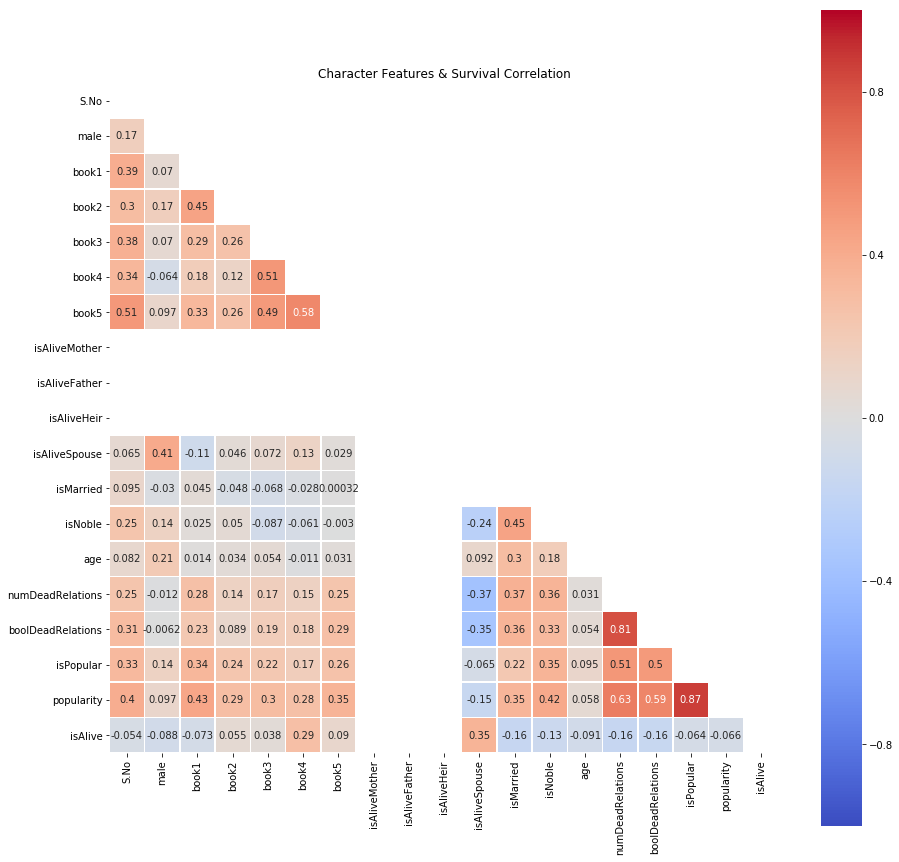

In [42]:
# Visualize correlations
plt.figure(figsize = (15,15))
sns.heatmap(corr_matrix, 
            mask = mask, 
            square=True, 
            annot=True,
            linewidths = .5, 
            cmap='coolwarm',
            vmin = -1, 
            vmax = 1)

plt.title("Character Features & Survival Correlation")
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Looking at the heatmap above, let's reflect on our initial questions. A strong correlation coefficent is greater than 0.8. A correlation under 0.5 is generally described as weak. There aren't any correlations: neither strong nor week in a positive or negative direction between a character's survival and any of the features in our dataframe. The largest correlation value for "isAlive" is whether the spouse is alive, which at 0.35 doesn't even meet the bar for a weak level of correlation. In the heatmap above, only the numeric columns were calculated, so it's possible there's a correlation between house and survival. The age variable is frequently missing, and may provide more signal if it's mapped to categories like "young", "middle-aged" and "elder" instead of exact ages.

### **DEALING WITH CLASS IMBALANCE**
The data is not going to be equally balanced with the same number of characters across each house. Let's take a closer look at the representation of each house in our overall dataset.  

In [48]:
# What is the representation of each house in the data?
df.house.value_counts() / len(df)

Night's Watch      0.241379
House Stark        0.165517
House Targaryen    0.142529
House Lannister    0.112644
House Greyjoy      0.094253
House Tyrell       0.082759
House Martell      0.066667
House Arryn        0.036782
House Baratheon    0.029885
House Tully        0.027586
Name: house, dtype: float64

Out of 435 characters, Night's Watch represents 24% of the data with 2.8% being from the smallest house, Tully. 

In [49]:
# How many characters per house?
df.groupby(['house']).count()

,S.No,name,male,culture,book1,book2,book3,book4,book5,isAliveMother,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
house,,,,,,,,,,,,,,,,,,,,,
House Arryn,16,16,16,4,16,16,16,16,16,0,...,0,3,16,16,3,16,16,16,16,16
House Baratheon,13,13,13,1,13,13,13,13,13,0,...,0,5,13,13,5,13,13,13,13,13
House Greyjoy,41,41,41,28,41,41,41,41,41,0,...,0,3,41,41,7,41,41,41,41,41
House Lannister,49,49,49,10,49,49,49,49,49,0,...,0,17,49,49,18,49,49,49,49,49
House Martell,29,29,29,18,29,29,29,29,29,0,...,0,3,29,29,14,29,29,29,29,29
House Stark,72,72,72,60,72,72,72,72,72,0,...,0,12,72,72,13,72,72,72,72,72
House Targaryen,62,62,62,42,62,62,62,62,62,0,...,0,26,62,62,41,62,62,62,62,62
House Tully,12,12,12,6,12,12,12,12,12,0,...,0,4,12,12,5,12,12,12,12,12
House Tyrell,36,36,36,6,36,36,36,36,36,0,...,0,11,36,36,7,36,36,36,36,36


In [75]:
# Group by house, survival
df.groupby(['house', 'isAlive']).count()

S.No  name  male  culture  book1  book2  book3  book4  \
house         isAlive                                                          
 Arryn        0           6     6     6        3      6      6      6      6   
              1          10    10    10        1     10     10     10     10   
 Baratheon    0           6     6     6        1      6      6      6      6   
              1           7     7     7        0      7      7      7      7   
 Greyjoy      0          14    14    14        6     14     14     14     14   
              1          27    27    27       22     27     27     27     27   
 Lannister    0          18    18    18        5     18     18     18     18   
              1          31    31    31        5     31     31     31     31   
 Martell      0           4     4     4        3      4      4      4      4   
              1          25    25    25       15     25     25     25     25   
 Stark        0          22    22    22       17     22     22     22     22   
              1          50    50    50       43     50     50     50     50   
 Targaryen    0          41    41    41       29     41     41     41     41   
              1          21    21    21       13     21     21     21     21   
 Tully        0           7     7     7        3      7      7      7      7   
              1           5     5     5        3      5      5      5      5   
 Tyrell       0           2     2     2        2      2      2      2      2   
              1          34    34    34        4     34     34     34     34   
Night's Watch 0          45    45    45        4     45     45     45     45   
              1          60    60    60        4     60     60     60     60   

                       book5  isAliveMother  isAliveFather  isAliveHeir  \
house         isAlive                                                     
 Arryn        0            6              0              0            0   
              1           10              0              0            0   
 Baratheon    0            6              0              0            0   
              1            7              0              0            0   
 Greyjoy      0           14              0              0            0   
              1           27              0              0            0   
 Lannister    0           18              0              0            0   
              1           31              0              0            0   
 Martell      0            4              0              0            0   
              1           25              0              0            0   
 Stark        0           22              0              0            0   
              1           50              0              0            0   
 Targaryen    0           41              0              0            0   
              1           21              0              0            0   
 Tully        0            7              0              0            0   
              1            5              0              0            0   
 Tyrell       0            2              0              0            0   
              1           34              0              0            0   
Night's Watch 0           45              0              0            0   
              1           60              0              0            0   

                       isAliveSpouse  isMarried  isNoble  age  \
house         isAlive                                           
 Arryn        0                    2          6        6    2   
              1                    1         10       10    1   
 Baratheon    0                    3          6        6    4   
              1                    2          7        7    1   
 Greyjoy      0                    1         14       14    2   
              1                    2         27       27    5   
 Lannister    0                   10         18       18    9   
              1           

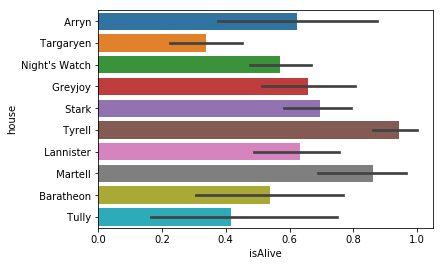

In [78]:
sns.barplot(x='isAlive', y='house', data=df)

# print(df.groupby(['house', 'isAlive']).mean()['isAlive'])
# print(df.groupby(['house', 'isAlive']).std()['isAlive'])
plt.show()